In [44]:
import numpy as np
import scipy
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import time
from matplotlib.animation import FuncAnimation

class FitzHugh_Nagumo_solver(object):

    def __init__ (self):
        pass
    
    def _fitzhugh_nagumo_initial_conditions(self):
        '''
        Define Fitzhugh_nagumo model for some initial conditions.
        Returns initial conditions
        '''
        u = np.zeros(self.N_dim)

        for i in range(self.N_dim):
            u[i] = 0.5*(1 + self.alpha) + 0.5*(1- self.alpha)*(np.tanh((np.sqrt(2)*(1-self.alpha)*self.x_range[i])/4))
        
        return u


    def __laplace_matrix(self):
        '''
        Defines Laplace Matrix with dimensions of X
        '''
        e = np.ones(self.N_dim)
        diagonals = [e, -2*e, e]
        offsets = [-1, 0, 1]
        self.L = scipy.sparse.spdiags(diagonals, offsets, self.N_dim, self.N_dim) /  self.h **2

        return self.L

    def FN_solver(self, x_0 : int, x_n: int, boundary_conditions: tuple = [0,1], step_size: float = 0.05,
                 time_steps: int = 8000, alpha: float = 0.13):

        self.h = step_size
        self.x_range = np.arange(x_0+self.h, x_n-self.h, self.h)
        self.alpha = alpha
        self.N_dim = len(self.x_range)
        self.k_N = time_steps
        lower, upper = boundary_conditions[:]
        self.bc = bc = np.concatenate(([lower], np.zeros(self.N_dim-2), [upper]))/self.h**2

        u = np.empty((self.N_dim, self.k_N))
        u[:,0] = self._fitzhugh_nagumo_initial_conditions()
        k = 0.2 * self.h**2
        L = self.__laplace_matrix()
        #int(np.ceil(42/k)/10) DO WE NEED THIS?!

        for i in range(1, self.k_N):
            u[:,i] = u[:,i-1] + k*( (L@u[:,i-1] + self.bc) + (u[:,i-1]**2 - u[:,i-1]**3 - self.alpha*u[:,i-1] + self.alpha*u[:,i-1]**2) )
        
        return u

In [45]:
trial = FitzHugh_Nagumo_solver()

In [47]:
u = trial.FN_solver(0,20)

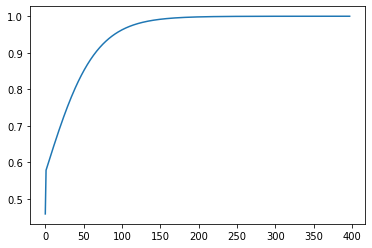

In [50]:
plt.plot(u[:,1])

In [53]:
trial.alpha

0.13